# Learning a Gaussian Mixture Model

In this notebook, we show how we can create a symbolic circuit with `cirkit` to create a simple Gaussian mixture model, compile it into a regular Pytorch model, and learn the cluster assigments using Adam.

Note that this is an illustrative example to show how to build symbolic circuits manually, and there are better ways of fitting Gaussian mixture models than with stochastic first-order optimization.

## Generate a simple dataset

First, we are going to use Pytorch distributions to generate a simple dataset composed of eight Gaussians distributed around the origin point.

In [72]:
import matplotlib.pyplot as plt
import torch.distributions as D
import torch
import math

In [73]:
radius = 2  # Distance of the centers from the origin
K = 8  # Number of clusters
mus = torch.tensor([
    [math.cos(2*math.pi*n / K) for n in range(K)],
    [math.sin(2*math.pi*n / K) for n in range(K)]
]).T * radius
sigma = .2  # Standard deviation

In [74]:
mix = D.Categorical(torch.ones(K,))
comp = D.Independent(D.Normal(mus, sigma), 1)
gmm = D.MixtureSameFamily(mix, comp)

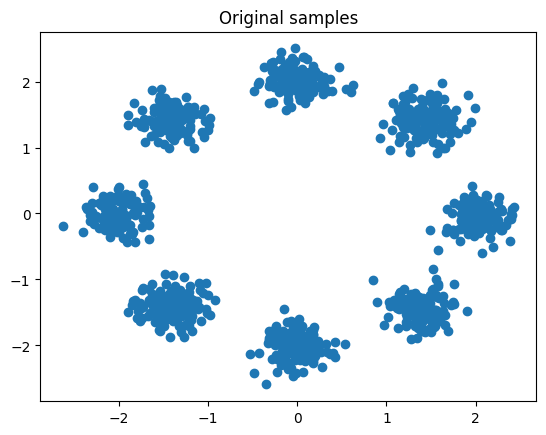

In [75]:
plt.scatter(*gmm.sample((1000,)).unbind(-1))
plt.title('Original samples')
plt.show()

## Create a symbolic circuit

Now, we build a simple mixture model using a symbolic circuit. To create these, we basically need to tell `cirkit` _what_ are the operations we want and _how_ are they connected. That is, we create circuits by defining the _graph_ of layers that compose it. 

In the case of a Gaussian mixture model, we need to create:
- Two Gaussian input layers (one per variable), that output as many values as the number of clusters we want to use.
- A Hadamard layer, which will combine these two Gaussian layers by cluster-wise multiplying the densities.
- A Sum layer with convex weights that will define the mixture weights.

Note that, as of now, Gaussian layers in `cirkit` are defined for univariate distributions, and thus we defined them as 2D isotropic Gaussians by multiplying two independent univariate Gaussians.

In [76]:
from cirkit.symbolic.circuit import Circuit, Scope
from cirkit.symbolic.layers import GaussianLayer, SumLayer, HadamardLayer
from cirkit.templates import utils

def build_symbolic_circuit() -> Circuit:
    # This parametrizes the mixture weights such that they add up to one.
    weight_factory = utils.parameterization_to_factory(utils.Parameterization(
        activation='softmax',   # Parameterize the sum weights by using a softmax activation
        initialization='uniform' # Initialize the sum weights by sampling from a standard normal distribution
    ))

    # We introduce one more mixture than in the original model
    # Again, SGD/Adam is not the best way to fit a (shallow) Gaussian mixture model
    units = K+1 
    
    g0 = GaussianLayer(Scope((0,)), units)
    g1 = GaussianLayer(Scope((1,)), units)
    prod = HadamardLayer(num_input_units=units, arity=2)
    sl = SumLayer(units, 1, 1, weight_factory=weight_factory)

    return Circuit(
        layers=[g0, g1, prod, sl],  # Layers that appear in the circuit (i.e. nodes in the graph)
        in_layers={  # Connections between layers (i.e. edges in the graph as an adjacency list)
            g0: [],
            g1: [],
            prod: [g0, g1],
            sl: [prod],
        },
        outputs=[sl]  # Nodes that are returned by the circuit
    )

In [77]:
# Build a symbolic complex circuit by overparameterizing a Quad-Tree (4) region graph, which is structured-decomposable
symbolic_circuit = build_symbolic_circuit()

# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {symbolic_circuit.is_smooth}')
print(f'  - Decomposability: {symbolic_circuit.is_decomposable}')
print(f'  - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}')

Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: True


## Learning Gaussian Mixture Models

In [78]:
import random
import numpy as np
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

dataset_size = 10000

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cpu')

# Load the MNIST data set and data loaders
data_train = TensorDataset(gmm.sample((dataset_size,)))
data_test = TensorDataset(gmm.sample((dataset_size//10,)))

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

### Compilation Step and Optimization

To compile the circuit, we instantiate a ```PipelineContext``` object and refer the reader to the [compilation options](../compilation-options) notebook for a tutorial on compiling circuits and on the meaning of the different flags.

In [79]:
from cirkit.pipeline import PipelineContext, compile

# Instantiate the pipeline context
ctx = PipelineContext(
    backend='torch',  # Choose PyTorch as compilation backend
    # ---- Use the evaluation semiring (R, +, x), where + is the numerically stable LogSumExp and x is the sum ---- #
    semiring='lse-sum',
    # ------------------------------------------------------------------------------------------------------------- #
    fold=True,     # Fold the circuit to better exploit GPU parallelism
    optimize=True  # Optimize the layers of the circuit
)

with ctx:  # Compile the circuits computing log |c(X)| and log |Z|
    circuit = compile(symbolic_circuit)

Next, we instantiate a PyTorch optimizer, such as Adam.

In [80]:
# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.01)

In the following training loop, we learn the parameters of the mixture model by minimizing the negative log-likelihood computed on training samples.

In [81]:
num_epochs = 30
step_idx = 0
running_loss = 0.0
running_samples = 0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    for i, (batch,) in enumerate(train_dataloader):
        # The circuit expects an input of shape (batch_dim, num_variables)
        batch = batch.to(device)

        log_likelihoods = circuit(batch)                 
        loss = -torch.mean(log_likelihoods)
        
        # Update the parameters of the circuits, as any other model in PyTorch
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
        step_idx += 1
        if step_idx % 50 == 0:
            average_nll = running_loss / running_samples
            print(f"Step {step_idx}: Average NLL: {average_nll:.3f}")
            running_loss = 0.0
            running_samples = 0

Step 50: Average NLL: 4.058
Step 100: Average NLL: 3.072
Step 150: Average NLL: 2.786
Step 200: Average NLL: 2.560
Step 250: Average NLL: 2.328
Step 300: Average NLL: 2.150
Step 350: Average NLL: 2.044
Step 400: Average NLL: 2.021
Step 450: Average NLL: 1.992
Step 500: Average NLL: 1.941
Step 550: Average NLL: 1.869
Step 600: Average NLL: 1.807
Step 650: Average NLL: 1.797
Step 700: Average NLL: 1.769
Step 750: Average NLL: 1.742
Step 800: Average NLL: 1.737
Step 850: Average NLL: 1.729
Step 900: Average NLL: 1.734
Step 950: Average NLL: 1.746
Step 1000: Average NLL: 1.730
Step 1050: Average NLL: 1.733
Step 1100: Average NLL: 1.737
Step 1150: Average NLL: 1.730
Step 1200: Average NLL: 1.735


Next, we evaluate the model on the test data.

In [82]:
with torch.no_grad():
    test_lls = 0.0
    for batch, in test_dataloader:
        batch = batch.to(device)

        log_likelihoods = circuit(batch)
        test_lls += log_likelihoods.sum().item()

    # Compute average test log-likelihood and bits per dimension
    average_ll = test_lls / len(data_test)
    print(f"Average test LL: {average_ll:.3f}")

Average test LL: -1.726


Now, we can visualize the learned mixture model by plotting its samples.

To this end, we simply sample the cluster assigments according to the values of the mixture weights, and then select those samples from the input layer.

In [83]:
with torch.no_grad():
    mixture_weights = circuit.layers[1].weight()
mixture_weights

tensor([[[0.1257, 0.1219, 0.0027, 0.1281, 0.1225, 0.1250, 0.1223, 0.1232,
          0.1287]]])

In [84]:
num_samples = 1000

clusters = D.OneHotCategorical(probs=mixture_weights.squeeze())
z = clusters.sample((num_samples,))

with torch.no_grad():    
    all_samples = circuit.layers[0].sample(num_samples)
    all_samples = all_samples.transpose(0, 2)

samples = all_samples[z.bool()]
samples.shape

torch.Size([1000, 2])

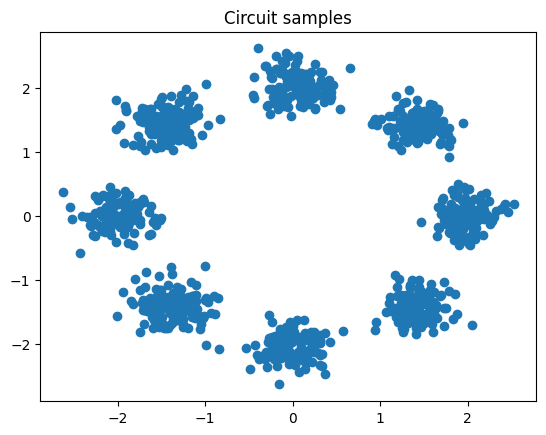

In [85]:
plt.scatter(*samples.unbind(-1))
plt.title('Circuit samples')
plt.show()

As we can observe in the plot above, we have properly learned to model the original distribution.